# Part 1
## DoWhy example

This exercise is based on [Confounding Example: Finding causal effects from observed data](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/dowhy_confounder_example.html#Confounding-Example:-Finding-causal-effects-from-observed-data)

Based on the concepts introduced in the previous lecture on estimating causal effects. The first part of the exercise is to use the DoWhy library to estimate causal effects on a dataset. 

In order to evaluate the precision of the estimation we need to simulate the dataset, so we know the true effect. To do this you can either:

1) simulate the dataset yourself based on the SCM principles;
2) use the funtion ```dowhy.datasets.linear_dataset``` to simulate the dataset for you.


In [58]:
import dowhy
from dowhy import datasets, CausalModel
import dowhy.datasets, dowhy.plotter

In [36]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 3,
        num_effect_modifiers=3,
        num_samples=5000,
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
        
df = data["df"]

In [37]:
df.head()

,X0,X1,X2,Z0,Z1,Z2,W0,v0,y
0,0.784267,-0.688945,0.171838,0.0,0.006156,0.0,3,True,10.210497
1,1.180747,-1.840738,-1.315478,0.0,0.647945,1.0,2,True,7.722272
2,-1.019777,-0.248736,0.736184,0.0,0.839827,1.0,3,True,7.451470
3,-0.343723,1.093728,-0.423484,0.0,0.559120,0.0,1,False,1.136655
4,2.112171,-1.714907,-2.079601,1.0,0.448821,0.0,2,True,8.517122


When you have the dataset causal effect using DoWhy.

### STEP 1: Model the problem as a causal graph

Once you have a dataset, you need to build the graph that generated the dataset. If you use the DoWhy function it will also generate the graph for you. Once you have the graph remember to plot it! Always make a visualisation if possible. 


In [42]:
model=CausalModel(
        data = df, # df is a pandas dataframe
        treatment=data["treatment_name"], # is stored in the dict we simulated
        outcome=data["outcome_name"], # is stored in the dict we simulated
        graph=data["gml_graph"] 
        )

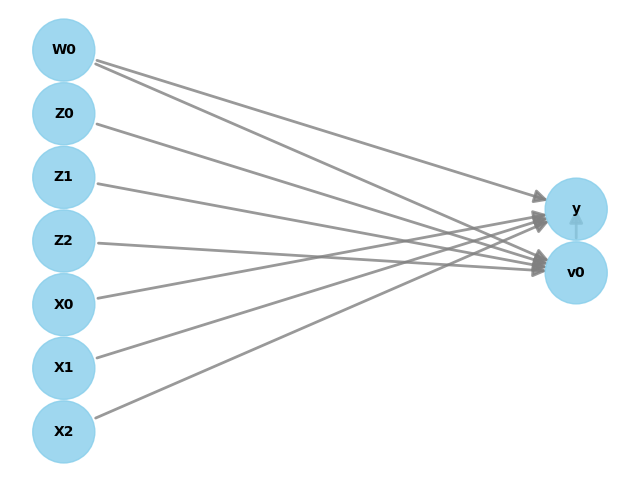

In [39]:
model.view_model()

### STEP 2: Identify causal effect using properties of the formal causal graph

Once the estimand is identified check it for backdoors, iv (instrumental variables) and frontdoors. If you are happy continue. Pause and consider what would you do if you were not happy with a given estimand? 


In [43]:
# determine if a desired causal effect can be identified when given a particular causal model
# kind of determining causal effects present in the data
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True) 
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                      -1⎤
 ⎢      d          ⎛      d            ⎞  ⎥
E⎢─────────────(y)⋅⎜─────────────([v₀])⎟  ⎥
 ⎣d[Z₂  Z₁  Z₀]    ⎝d[Z₂  Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z2,Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z2,Z1,Z0}→{v0}, then ¬({Z2,Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### STEP 3: Estimate the causal effect

Estimate the effect and evaluate it. 


In [61]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [60]:
# estimate causal effect based on the identified estimand
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_matching', # could have chosen iv/frontdoor instead of backdoor, we don't look at iv
                                 target_units='att')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

## Realized estimand
b: y~v0+W0
Target units: att

## Estimate
Mean value: 6.529453729102819



In [51]:
est_pss = model.estimate_effect(identified_estimand,method_name="backdoor.propensity_score_stratification",
                                method_params={'num_strata':50, 'clipping_threshold':5})
print(est_pss)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d           
─────(E[y|W0])
d[v₀]         
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

## Realized estimand
b: y~v0+W0
Target units: ate

## Estimate
Mean value: 6.52361139518142



### OPTIONAL Step 4: Refuting the estimate

There are several techniques to refute the estimate, in the example link above a few is given. You can try them out and consider what is the reasons for doing them. 

# Part 2
## Consider how to apply causal inference to your own project.

For your own spend some time considering could causal inference be useful, consider both 
why and why not. 

What sort of questions could causal inference solve in your project?

For causal inference to be useful several things need to be considered: 

- What is the data generating process (DGP)?
- How to graph the DGP?
    - How would you find the information needed to graph it?
    - What is the relation between the different nodes in the graph?
- What is the treatment variable?
- Consider the estimand.
    - Anything that needs to be changed?
- How would you interpret and use any finding? 


